author : 
> Nabiel Husein Shihab / nabielshihab@hotmail.com

# **Apa itu b-value? Kenapa kita perlu analisis b-value?**

***
Terdapat sebuah hubungan sistematis antara **magnitudo gempa bumi (M)** dan **frekuensi kemunculannya (N)** dalam suatu daerah dan periode waktu tertentu, yaitu **Gutenberg-Richter (GR) Law** (Naylor dkk., 2009). 


Gutenberg–Richter Law dapat diungkapkan sebagai berikut :

> `log_10⁡(𝑁) = 𝑎 − 𝑏𝑀`

>Nilai konstanta 𝑎 berkaitan dengan jumlah total event mikroseismik di atas ***Mc (magnitude of completeness)***. ***Mc*** didefinisikan sebagai magnitudo terendah di mana 100% gempa bumi dalam volume ruang-waktu terdeteksi.
>Nilai konstanta ***b (b-value)*** sering dikaitkan dengan kondisi stress batuan pada suatu zona tertentu.

<img src="Figures/bvalue_0.png" width="700"/>

GR law adalah salah satu dasar teori yang digunakan dalam interpretasi data seismik dan **analisa kebencanaan** (Wesseloo, 2014). Chun-lai dkk. (2009) menyatakan bahwa konstanta 𝑏 (b-value) merupakan hubungan yang proporsional antara event gempabumi yang besar dan kecil. Perubahan b-value pada suatu area menandakan keadaan gangguan pada batuan medium. Perubahan b-value berhubungan dengan seluruh proses dari aktivitas gempabumi. Wesseloo (2014) menyatakan bahwa evaluasi variasi b-value spasial merupakan salah satu kunci dalam peta kebencanaan seismik. Estimasi b-value spasial berguna untuk interpretasi mekanisme batuan secara umum dan evaluasi kebencanaan seismik. Parameter b-value juga merupakan parameter yang berharga dalam interpretasi deformasi massa batuan dan mekanisme failure. Peningkatan dari heterogenitas struktur material dapat menghasilkan b-value yang tinggi, sedangkan kenaikan dari applied shear stress atau effective stress dapat menurunkan b-value. Interpretasi umum b-value dalam mekanisme deformasi massa batuan dapat dilihat pada tabel di bawah.

<img src="Figures/bvalue_1.png" width="700"/>


# **Flowchart**

# <img src="Figures/bvalue_2.png" width="400"/>

***

# **`LET'S CODE`**

### Import Modules

In [1]:
from library.mag_of_completeness import *
from library.curve_fitting_method import *
from library.visualization import *

import pandas as pd
import matplotlib.pyplot as plt

## 1. Buka katalog

In [2]:
file_name = 'dataset\\Magnitude_Catalog.csv'
catalog = pd.read_csv(file_name)

print(f"number of catalog rows    : {catalog.shape[0]}")
print(f"number of catalog columns : {catalog.shape[1]}")
catalog.head()

number of catalog rows    : 1193
number of catalog columns : 4


,X,Y,Z,M
0,128.263141,-3.592250,-9.398,3.263406
1,128.379281,-3.619712,-9.167,4.357416
2,128.356440,-3.467614,-12.305,2.573589
3,128.351284,-3.615661,-11.570,2.970120
4,128.357585,-3.619155,-10.153,2.966920


## 2. Menghitung Mc dan maxmag

Dua hal ini merupakan parameter yang diperlukan untuk menghitung b-value. Namun sebelum kita menghitung Mc dan maxmag, kita perlu melihat **distribusi frekuensi-magnitudo (DFM)** dari sebuah katalog. 

### 2.1 Membentuk DFM
Terdapat madzhab berbeda untuk menghitung b-value. Ada yang berpendapat bahwa b-value harus dihitung dari DFM kumulatif, namun ada juga pendapat mengatakan b-value dihitung dari DFM nonkumulatif. Dalam sesi ini, kita akan menggunakan DFM nonkumulatif.  Untuk membentuk DFM nonkumulatif, kita akan memanggil fungsi `fmd` yang ada di dalam modul `mag_of_completeness.py`.

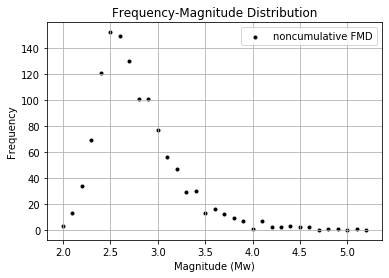

In [3]:
# ekstrak magnitudo dari katalog dan menentukan binwidth untuk pembentukan DFM
mag = catalog['M']
mbin = 0.1

# membentuk DFM
FMD = fmd(mag, mbin)
m = FMD[0]
cum = FMD[1]
noncum = FMD[2]

# plot DFM
plt.figure()
plt.scatter(m, noncum, marker = ".", color = "k", label = "noncumulative FMD")
plt.title("Frequency-Magnitude Distribution")
plt.xlabel("Magnitude (Mw)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

### 2.2 Menghitung Mc dan maxmag

pilihan metode estimasi Mc:
>1. `maximum curvature (maxc)`
2. `goodness-of-fit test (gft)`
3. `Mc by b-value stability (mbs)`

metode estimasi maximum magnitude:
>`maxmag = 𝑋𝑚𝑎𝑥1 + (𝑋𝑚𝑎𝑥1 – 𝑋𝑚𝑎𝑥2)`


> maxmag = maximum magnitude,
Xmax1 = magnitudo terbesar pertama dalam katalog data,
Xmax2 = magnitude terbesar kedua dalam katalog data


Ketiga metode estimasi Mc tersebut dapat diterapkan dengan memanggil masing-masing fungsinya ke dalam program ini. Namun kali ini kita akan mencoba metode `maxc`. Dikarenakan fungsi estimasi Mc berada di dalam modul `mag_of_completeness.py` maka kita tidak perlu import lagi.

In [4]:
# metode estimasi Mc
mc_method = maxc

# melakukan bootstrap resampling sebanyak nbsample
nbsample = 200
mc_bootstrap = np.zeros(nbsample)
for i in range(nbsample):
    magbs = pd.Series(np.random.choice(mag, size=len(mag)))
    mc_bootstrap[i] = mc_method(magbs, mbin)[0]

# ekstrak nilai rata-rata dan standar deviasi dari Mc bootstrap 
mc_mean = np.nanmean(mc_bootstrap)
mc_sd = np.nanstd(mc_bootstrap)
mc_sdl = mc_mean - mc_sd
mc_sdr = mc_mean + mc_sd

# fiksasi Mc
mc_test = round_up(mc_mean)
if mc_test <= mc_mean + mc_sd:
    mc = mc_test
else:
    mc = round(mc_mean, 1)

# estimasi maxmag
sorted_mag = sorted(mag, reverse=True)
max1 = sorted_mag[0]
for i in range(len(sorted_mag)):
    if sorted_mag[i] != max1:
        max2 = sorted_mag[i]
        break
maxmag = round(max1 + (max1 - max2), 1)
# maxmag = round(max1, 1)

print(f"Magnitude of Completeness : {mc}")
print(f"Maximum magnitude : {maxmag}")

Magnitude of Completeness : 2.6
Maximum magnitude : 5.4


### 2.3 Membentuk DFM untuk perhitungan b-value

Untuk membentuk DFM yang dibatasi oleh Mc dan maxmag, kita akan menggunakan fungsi `fmd_bvalue` yang ada di dalam modul `mag_of_completeness.py`. Namun karena kita sudah memanggil semua fungsi di dalam modul tersebut pada tahap sebelumnya, maka kita tidak perlu import lagi

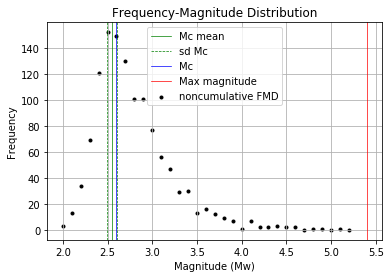

In [5]:
# seleksi magnitudo berdasarkan Mc dan maxmag
mag_bvalue = mag[(mag >= mc) & (mag <= maxmag)]

# membentuk DFM untuk perhitungan b-value
FMD_bvalue = fmd_bvalue(mag_bvalue, mc, maxmag, mbin)
x = FMD_bvalue[0]
cum_bvalue = FMD_bvalue[1]
y = FMD_bvalue[2]
d1 = pd.DataFrame({"x": np.array(x), "y": np.array(y)})

# membentuk variabel xo dan yo
yo = y[list(np.where(y != 0)[0])]
xo = x[list(np.where(y != 0)[0])]
log_yo = [math.log10(elem) for elem in yo]
d2 = pd.DataFrame({"xo": np.array(xo), "yo": np.array(yo), "log_yo": np.array(log_yo)})

# plot DFM detail
plt.figure()
plt.scatter(m, noncum, marker = ".", color = "k", label = "noncumulative FMD")
plt.axvline(mc_mean, linestyle = "solid", color = "green", linewidth = 0.7, label = "Mc mean")
plt.axvline(mc_sdl, linestyle = "dashed", color = "green", linewidth = 0.7, label = "sd Mc")
plt.axvline(mc_sdr, linestyle = "dashed", color = "green", linewidth = 0.7)
plt.axvline(mc, linestyle = "solid", color = "blue", linewidth = 0.7, label = "Mc ")
plt.axvline(maxmag, linestyle = "solid", color = "red", linewidth = 0.7, label = "Max magnitude")
plt.title("Frequency-Magnitude Distribution")
plt.xlabel("Magnitude (Mw)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

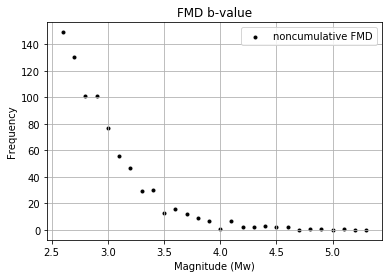

In [6]:
# plot DFM b-value
plt.figure()
plt.scatter(x, y, marker = ".", color = "k", label = "noncumulative FMD")
plt.title("FMD b-value")
plt.xlabel("Magnitude (Mw)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

DFM inilah yang akan digunakan untuk menghitung b-value.

## 3. Menghitung b-value, ketidakpastiannya, dan 95% confidence interval

pilihan metode Curve fitting:
>1. `LM with Gaussian residual (b-value glog)`
2. `GLM with Gaussian residual (b-value glin)`
3. `GLM with Poisson residual (b-value pois)`


Ketiga metode curve fitting tersebut dapat diterapkan dengan memanggil masing-masing fungsinya ke dalam program ini. Namun kali ini kita akan mencoba metode `b-value pois`. Dikarenakan fungsi curve fitting berada di dalam modul `curve_fitting_method.py` maka kita perlu import fungsi tersebut.

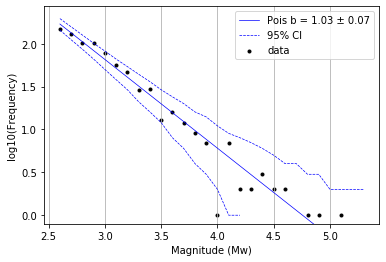

In [8]:
# curve fitting
cv_data = fit_data_with_poisson(d1,x, xo, log_yo)

# plot b-value dan 95% confidence interval
plot_bvalue(cv_data, 'b-value pois')

### Daftar Pustaka:
1. Chun-lai, W., Ai-xiang, W., Xiao-hui, L., dan Rui, L. (2009): Study on fractal characteristics of b-value with microeismic activity in deep mining, Procedia Earth and Planetary Science. 
2. Naylor, M., Greenhough, J., McCloskey, J., Bell, A. F., dan Main, I. G. (2009): Statistical evaluation of characteristic earthquakes in the frequencymagnitudo distributions of Sumatra and other subduction zone regions, Geophysical Research Letters, 36.
3. Kijko, A. dan Funk, C. W. (1994): The Assesment of Seismic Hazard in Mines. The Journal of the South African Institute of Mining and Metallurgy.
4. Mignan, A. dan Woessner, J. (2012): Estimating The Magnitude of completeness in Earthquake Catalogs. Community Online Resource for Statistical Seismicity Analysis. 
5. Wesseloo, J. (2014): Evaluation of the spatial variation of bvalue, The Journal of The Southern African Institute of Mining and Metallurgy, 114.